# Amino Acids


Many of the possible uptakes for MED4 are amino acid.

The goal of this notebook is to answer the questions
- Why are only a subset of amino acids in the list?
   1. run pFBA and search for the reactions that enable production of all amino acids from the amino acids on the uptake list, do they simply produce ammonium?
   2. use gap filling to identify missing reactions that may enable growth on the amino acids that are not sufficient for growth
GEMdiff


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize
import os


In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [3]:
from bokeh.models import Range1d, Plot
from bokeh.plotting import from_networkx


In [4]:
import subprocess
import time


In [5]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [6]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [9]:
import networkx as nx

In [10]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   ["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   ["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [11]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'mid' : m.id,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

In [12]:
pro_df = pd.read_excel('data/PRO_N_sources.xlsx', sheet_name='uptake')

In [13]:
codes_df = pd.read_excel(os.path.join('data', 'metabolite_codes.xlsx'), index_col=0)


# Import model and manipulate based on Ofaim at el

In [14]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7_with_formula.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [15]:
model = cobra.io.read_sbml_model(model_fpath)

In [16]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [17]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [18]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [19]:
model

Name,COBRAModel
Memory address,23c1a13b1c0
Number of metabolites,802
Number of reactions,994
Number of genes,595
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [20]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x23c1a1b9f40
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R01395, R07316, R03546, R10949"


In [21]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,C:\Users\oweisberg\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


# Get list of Amino Acids

In [22]:
aa = model.metabolites.get_by_id('amino_acid_pool[c]')

In [23]:
dna = model.metabolites.get_by_id('Free_nucleic_acids[c]')
dna

Metabolite identifier,Free_nucleic_acids[c]
Name,Free nucleic acids
Memory address,0x23c1a15c2b0
Formula,None
Compartment,c
In 2 reaction(s),"BIOMASS, BFreenucleicacids"


In [24]:
t = model.reactions.get_by_id('BIOMASS')

In [25]:
t.metabolites

{<Metabolite amino_acid_pool[c] at 0x23c1a12b730>: -0.0234984300617847,
 <Metabolite H2O[c] at 0x23c1a12bee0>: -104.0,
 <Metabolite ATP[c] at 0x23c1a12b6d0>: -104.0,
 <Metabolite Cell_wall[c] at 0x23c1a15c220>: -0.0559910868023904,
 <Metabolite deoxyribonucleic_acids[c] at 0x23c1a15c250>: -0.013126709206928,
 <Metabolite Free_nucleic_acids[c] at 0x23c1a15c2b0>: -0.00111921401802897,
 <Metabolite lipid[c] at 0x23c1a15c2e0>: -0.12843107464803,
 <Metabolite pigments[c] at 0x23c1a15c310>: -0.0425402613187481,
 <Metabolite Protein[c] at 0x23c1a15c340>: -0.649245416793275,
 <Metabolite ribonucleic_acids[c] at 0x23c1a15c370>: -0.0525068368277119,
 <Metabolite BioPool[c] at 0x23c1a15c3a0>: -0.0324116276714271,
 <Metabolite Bmineral[c] at 0x23c1a15c3d0>: -0.0268408791654006,
 <Metabolite biomass[c] at 0x23c1a12b6a0>: 1.0,
 <Metabolite ADP[c] at 0x23c1a12b0a0>: 104.0,
 <Metabolite Orthophosphate[c] at 0x23c1a12b100>: 104.0}

In [26]:
BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
amino_acid_metabolites

[<Metabolite L_Glutamate[c] at 0x23c1a12b610>,
 <Metabolite Glycine[c] at 0x23c1a12ba60>,
 <Metabolite L_Alanine[c] at 0x23c1a12ba90>,
 <Metabolite L_Lysine[c] at 0x23c1a12ba00>,
 <Metabolite L_Aspartate[c] at 0x23c1a12bb50>,
 <Metabolite L_Arginine[c] at 0x23c1a12bf70>,
 <Metabolite L_Glutamine[c] at 0x23c1a12be80>,
 <Metabolite L_Serine[c] at 0x23c1a12bfa0>,
 <Metabolite L_Methionine[c] at 0x23c1a12bdf0>,
 <Metabolite L_Tryptophan[c] at 0x23c1a12b9a0>,
 <Metabolite L_Phenylalanine[c] at 0x23c1a12b520>,
 <Metabolite L_Tyrosine[c] at 0x23c1a1302b0>,
 <Metabolite L_Leucine[c] at 0x23c1a130280>,
 <Metabolite L_Histidine[c] at 0x23c1a137640>,
 <Metabolite L_Proline[c] at 0x23c1a1371f0>,
 <Metabolite L_Asparagine[c] at 0x23c1a137d60>,
 <Metabolite L_Valine[c] at 0x23c1a137e50>,
 <Metabolite L_Threonine[c] at 0x23c1a137910>,
 <Metabolite L_Isoleucine[c] at 0x23c1a27e9a0>,
 <Metabolite L_Cystine[c] at 0x23c1a27ed60>]

In [27]:
BFreenucleicacids_metabolites_dict = model.reactions.BFreenucleicacids.metabolites
dna_metabolites = [m for m in BFreenucleicacids_metabolites_dict if BFreenucleicacids_metabolites_dict[m] < 0]
dna_metabolites

[<Metabolite Uracil[c] at 0x23c1a1303a0>,
 <Metabolite Adenine[c] at 0x23c1a137490>,
 <Metabolite Adenosine[c] at 0x23c1a137a90>,
 <Metabolite Thymidine[c] at 0x23c1a137af0>,
 <Metabolite Guanine[c] at 0x23c1a137d00>,
 <Metabolite Inosine[c] at 0x23c1a1378b0>,
 <Metabolite Uridine[c] at 0x23c1a1377f0>,
 <Metabolite Deoxyguanosine[c] at 0x23c1a137280>,
 <Metabolite Cytosine[c] at 0x23c1a27e940>,
 <Metabolite Guanosine[c] at 0x23c1a27e970>,
 <Metabolite Cytidine[c] at 0x23c1a27ed30>,
 <Metabolite Deoxyuridine[c] at 0x23c1a27ee80>,
 <Metabolite Deoxyadenosine[c] at 0x23c1a27eee0>,
 <Metabolite Deoxycytidine[c] at 0x23c1a1b9460>,
 <Metabolite Xanthosine[c] at 0x23c1a1b9fa0>,
 <Metabolite Deoxyribose[c] at 0x23c1a1b9fd0>]

In [28]:
model.reactions.BFreeaminoacids.summary()

In [29]:
amino_acid_metabolites[15].summary()

Percent,Flux,Reaction,Definition
100.00%,0.005907,R00485,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c]
Percent,Flux,Reaction,Definition
7.01%,-0.000414,BFreeaminoacids,0.25719 Glycine[c] + 1.0449 L_Alanine[c] + 0.20897 L_Arginine[c] + 0.27327 L_Asparagine[c] + 0.46616 L_Aspartate[c] + 0.04019 L_Cystine[c] + 2.0415 L_Glutamate[c] + 1.3342 L_Glutamine[c] + 0.22504 L_Histidine[c] + 0.10448 L_Isoleucine[c] + 0.1286 L_Leucine[c] + 0.17682 L_Lysine[c] + 0.04019 L_Methionine[c] + 0.04019 L_Phenylalanine[c] + 0.41392 L_Proline[c] + 0.37775 L_Serine[c] + 0.24916 L_Threonine[c] + 0.01607 L_Tryptophan[c] + 0.04822 L_Tyrosine[c] + 0.1286 L_Valine[c] --> amino_acid_pool[c]
92.99%,-0.005493,BProtein,34.99 ATP[c] + 0.57844 Glycine[c] + 0.54397 L_Alanine[c] + 0.51716 L_Arginine[c] + 0.13121 L_Asparagine[c] + 0.39361 L_Aspartate[c] + 0.13791 L_Cystine[c] + 0.67517 L_Glutamate[c] + 0.22506 L_Glutamine[c] + 0.19153 L_Histidine[c] + 0.32178 L_Isoleucine[c] + 0.6474 L_Leucine[c] + 0.57844 L_Lysine[c] + 0.41373 L_Methionine[c] + 0.25666 L_Phenylalanine[c] + 0.39456 L_Proline[c] + 0.0011644 L_Selenocysteine[c] + 0.11644 L_Selenomethionine[c] + 0.39456 L_Serine[c] + 0.40989 L_Threonine[c] + 0.053629 L_Tryptophan[c] + 0.18005 L_Tyrosine[c] + 0.53631 L_Valine[c] --> 34.99 ADP[c] + 34.99 Orthophosphate[c] + Protein[c]


# What are the reactions used to generate each of the amino acids?

In [30]:
pro_df.head()

,Unnamed: 0,uptake,objective_value,reaction,metabolite,mid,N,C
0,0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],Guanosine[e],True,True
1,1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,L_Aspartate[e],True,True
2,2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],Glutathione[e],True,True
3,3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,L_Glutamine[e],True,True
4,4,L_SerineEX,0.118972,L_SerineEX,L-Serine,L_Serine[e],True,True


In [31]:
# get the internal metabolite and internal transfer reaction from the exchange reaction
# needed because the exchange reaction does not contain the internal metabolite
def get_trans_reaction_and_internal_metabolite(met1):
    r_met1 = model.reactions.get_by_id(met1)
    m_met1_list = list(r_met1.metabolites.keys())
    assert(len(m_met1_list) ==1)
    m_external_met1 = m_met1_list[0]
    r_trans_list = [r for r in m_external_met1.reactions if r is not r_met1]
    assert(len(r_trans_list) ==1)
    r_trans = r_trans_list[0]
    m_internal_met1_list = [m for m in r_trans_list[0].metabolites.keys() if m is not m_external_met1]
    if (len(m_internal_met1_list) >1):
        # cyanate ABC transporter has more than 1
        m_internal_met1_list = [m for m in m_internal_met1_list if m.name == m_external_met1.name]
    assert(len(m_internal_met1_list) ==1)
    m_internal_met1 = m_internal_met1_list[0]
    return (r_trans, m_internal_met1, m_external_met1)

In [32]:
def get_products(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.reactants
    else:
        return r.products
    

In [33]:
def get_reactants(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.products
    else:
        return r.reactants
    

In [34]:
def get_pfba_flux(r, pfba_solution):
    f = pfba_solution.get_primal_by_id(r.id)
    if r.reversibility and (f < 0):
        return -f
    else:
        return f
    

In [35]:
def get_consuming_reactions(m, pfba_solution):
    reaction_list =  [
        r 
        for r in m.reactions 
        if ((m not in get_products(r, pfba_solution)) and
            (get_pfba_flux(r, pfba_solution) > 0))
    ]

    flux_list = [get_pfba_flux(r, pfba_solution)  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [36]:
def get_producing_reactions(m, pfba_solution):
    reaction_list =  [
        r for r in m.reactions 
        if (r not in get_consuming_reactions(m, pfba_solution)) and 
        (get_pfba_flux(r, pfba_solution) != 0)
    ]

    flux_list = [np.abs(get_pfba_flux(r, pfba_solution))  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [37]:
def get_percent_produced(met1, reaction1, pfba_solution):
    """ 
    what is the percent of flux of r out of the total reactions producing m
    how significant is r in m production
    """
    print(met1, reaction1)
    percent_list = [p for (r,f,p) in get_producing_reactions(met1, pfba_solution) if r == reaction1]
    if len(percent_list) == 1:
        #print(f'!!!!reaction {reaction1.id} FOUND in metabolite {met1}')
        return percent_list[0]
    
    if len(percent_list) == 0:
        if get_pfba_flux(reaction1, pfba_solution) != 0:
            print(f'reaction {reaction1.id} not found in metabolite {met1}')
        return 0
    assert(len(percent_list)>=2, f'reaction {reaction1.id} found more than once in metabolite {met1}')
    

<>:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\oweisberg\AppData\Local\Temp\ipykernel_20884\428528453.py:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(percent_list)>=2, f'reaction {reaction1.id} found more than once in metabolite {met1}')


In [38]:
from enum import Enum, auto
class DFS_STATUS(Enum):
     VISITED = auto()
     FOUND = auto()
     NOT_FOUND = auto()

In [39]:
def get_path_backwards(cur_met, uptake_metabolite, visited_set, found_set, pfba_solution):
    found_paths = list()
    final_status = DFS_STATUS.NOT_FOUND
        
    if cur_met in visited_set:
        return (DFS_STATUS.VISITED, [])
    if cur_met == uptake_metabolite:
        return (DFS_STATUS.NOT_FOUND, [])
    visited_set.add(cur_met)
    metabolites_to_skip= ['H2O[c]','H[c]','ADP[c]','ATP[c]', 'NADP[c]', 'NADPH[c]']
    metabolites_to_skip= ['H2O[c]','H[c]']
    reactions_to_skip = ['BProtein', 'Bpool', 'BFreeaminoacids', 'BFreenucleicacids']
    #metabolites_to_skip= []
    if cur_met.id in metabolites_to_skip:
        return (DFS_STATUS.NOT_FOUND, [])
    if not 'N' in cur_met.elements:
        return (DFS_STATUS.NOT_FOUND, [])

    r_producers = get_producing_reactions(cur_met, pfba_solution)
    for (r,f,percent_production) in r_producers:
        
        if r.id in reactions_to_skip:
            continue
        #visited.add(r)
        if percent_production < 1e-2:
            # less than one percent - not interesting
            continue
        m_producing_metabolites = get_reactants(r, pfba_solution)
        # m >>> r >>> cur_met
        for m in m_producing_metabolites:
            if m == uptake_metabolite:
                #found_set.add(m)
                return (DFS_STATUS.FOUND, [[(cur_met, m, r, percent_production)]])
            if m in found_set:
                _status, _path = (DFS_STATUS.FOUND, [[(cur_met, m, r, percent_production)]])
            else:
                _status, _path = get_path_backwards(m, uptake_metabolite, visited_set, found_set,pfba_solution)
            if _status is DFS_STATUS.FOUND:
                #found_set.add(m)
                path_list = [p + [(cur_met, m ,r, percent_production)] for p in _path]
                found_paths += path_list
                final_status = DFS_STATUS.FOUND
    return (final_status, found_paths)
    

In [40]:
def pathlist_to_dataframe(paths, pfba_solution, met1):
    df_paths = pd.DataFrame.from_records([
        {
            'path_id' : i,
            'Index' : j,
            'Uptake' : met1,
            'Reactant' : m_reactant.name,
            'Product' : m_product.name,
            'Reaction'   : r.id,
            'Name' : r.name,
            'Flux'          : get_pfba_flux(r, pfba_solution),
            'Definition'    : r.reaction,
            'Percent_Production' : percent,
            'Group' :  ','.join([g.name for g in model.groups if r in g.members]),
        }
        for i,p in enumerate(paths, start=1)
        for j,(m_product, m_reactant ,r,percent) in enumerate(p, start=1)
    ])   
    return df_paths


In [41]:
def get_paths_to_aa(model, met1):
    print (met1)
    met1_paths = list()

    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        pfba_solution = cobra.flux_analysis.pfba(model)
        fva_fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)

        
        met1_trans, met1_metabolite, met1_metabolite_ext = get_trans_reaction_and_internal_metabolite(met1)        
        BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
        amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict 
                                  if (BFreeaminoacids_metabolites_dict[m] < 0) and (m !=  met1_metabolite)]
        BFreenucleicacids_metabolites_dict = model.reactions.BFreenucleicacids.metabolites
        dna_metabolites = [m for m in BFreenucleicacids_metabolites_dict 
                           if (BFreenucleicacids_metabolites_dict[m] < 0) and (m !=  met1_metabolite)]
        for i in amino_acid_metabolites + dna_metabolites:
            found_set = set()
            #print ('\t',i)
            visited_set = set()
            _status, temp_paths = get_path_backwards(i, met1_metabolite_ext, visited_set, found_set, pfba_solution)    
            
            met1_paths.extend(temp_paths)
        return (pathlist_to_dataframe(met1_paths, pfba_solution, met1), pfba_solution, fva_fluxes)
        

In [42]:
res_list = [get_paths_to_aa(model, uptake) for uptake in pro_df.uptake]
df_paths_list,pfba_solution_list, fva_fluxes_list = list(zip(*res_list))    

GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
L_CystineEX
L_AlanineEX
L_LeucineEX
GlycineEX
UreaEX
AmmoniaEX
L_GlutamateEX
L_ArginineEX
CyanateEX
L_ValineEX
GuanineEX


In [43]:
df_paths_list[6]

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group
0,1,1,L_AlanineEX,L-Alanine,L-Alanine,AlanineTRANS,L_Alanine Transport,1.021992,L_Alanine[c] <=> L_Alanine[e],0.491735,Transport
1,1,2,L_AlanineEX,L-Alanine,Glycine,R00369,L-Alanine:glyoxylate aminotransferase,0.970963,Glyoxylate[c] + L_Alanine[c] <=> Glycine[c] + Pyruvate[c],0.454493,"Alanine, aspartate and glutamate metabolism"
2,1,3,L_AlanineEX,Glycine,L-Glutamate,R00372,Glycine:2-oxoglutarate aminotransferase,0.970963,2_Oxoglutarate[c] + Glycine[c] <=> Glyoxylate[c] + L_Glutamate[c],0.466990,"Glycine, serine and threonine metabolism"
3,2,1,L_AlanineEX,L-Alanine,L-Alanine,AlanineTRANS,L_Alanine Transport,1.021992,L_Alanine[c] <=> L_Alanine[e],0.491735,Transport
4,2,2,L_AlanineEX,L-Alanine,Glycine,R00369,L-Alanine:glyoxylate aminotransferase,0.970963,Glyoxylate[c] + L_Alanine[c] <=> Glycine[c] + Pyruvate[c],0.454493,"Alanine, aspartate and glutamate metabolism"
...,...,...,...,...,...,...,...,...,...,...,...
566,34,18,L_AlanineEX,Malonyl-CoA,CoA,R01626,Malonyl-CoA:[acyl-carrier-protein] S-malonyltransferase,0.686746,Acyl_carrier_protein[c] + Malonyl[c] --> CoA[c] + Malonyl_acyl_carrier_protein[c],0.312833,Fatty acid biosynthesis
567,34,19,L_AlanineEX,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,1.021595,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],0.401214,Citrate cycle (TCA cycle)
568,34,20,L_AlanineEX,NADH,NAD+,R10221,R10221,1.061256,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],0.416440,
569,34,21,L_AlanineEX,NAD+,Xanthosine 5-phosphate,R01130,IMP:NAD+ oxidoreductase,0.007365,H2O[c] + IMP[c] + NAD[c] --> H[c] + NADH[c] + Xanthosine_5_phosphate[c],0.500000,Purine metabolism


In [44]:
def _pfba_to_df (uptake, solultion):
    df = solultion.to_frame()
    df['Uptake'] = uptake
    return df
pfba_df = pd.concat([_pfba_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, pfba_solution_list)])


In [45]:
def _fva_to_df (uptake, df):
    df['Uptake'] = uptake
    return df
fva_df = pd.concat([_fva_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, fva_fluxes_list)])


In [46]:
fva_df = fva_df.reset_index().rename(columns={'index': 'Reaction'})

In [47]:
pfba_df = pfba_df.reset_index().rename(columns={'index': 'Reaction'})

In [48]:
flux_df = pd.merge(fva_df, pfba_df, on=['Uptake', 'Reaction'])

In [49]:
pfba_df.loc[np.isclose(pfba_df.fluxes, 0, atol=1e-5), 'fpba_status'] ='inactive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes > 1e-5), 'fpba_status'] ='positive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes < -1e-5), 'fpba_status'] ='negative'


In [50]:
pfba_df.head()

,Reaction,fluxes,reduced_costs,Uptake,fpba_status
0,R01055,0.000000,2.00000,GuanosineEX,inactive
1,R00546,0.000000,2.00000,GuanosineEX,inactive
2,R05605,7.889429,-2.00000,GuanosineEX,positive
3,R00346,0.000000,18.10219,GuanosineEX,inactive
4,R00355,0.532450,-2.00000,GuanosineEX,positive


In [51]:
def _get_group(rid):
    r = model.reactions.get_by_id(rid)
    return ','.join([g.name for g in model.groups if r in g.members])
pfba_df['Group'] = pfba_df.Reaction.map(_get_group)

In [52]:
import colorcet as cc

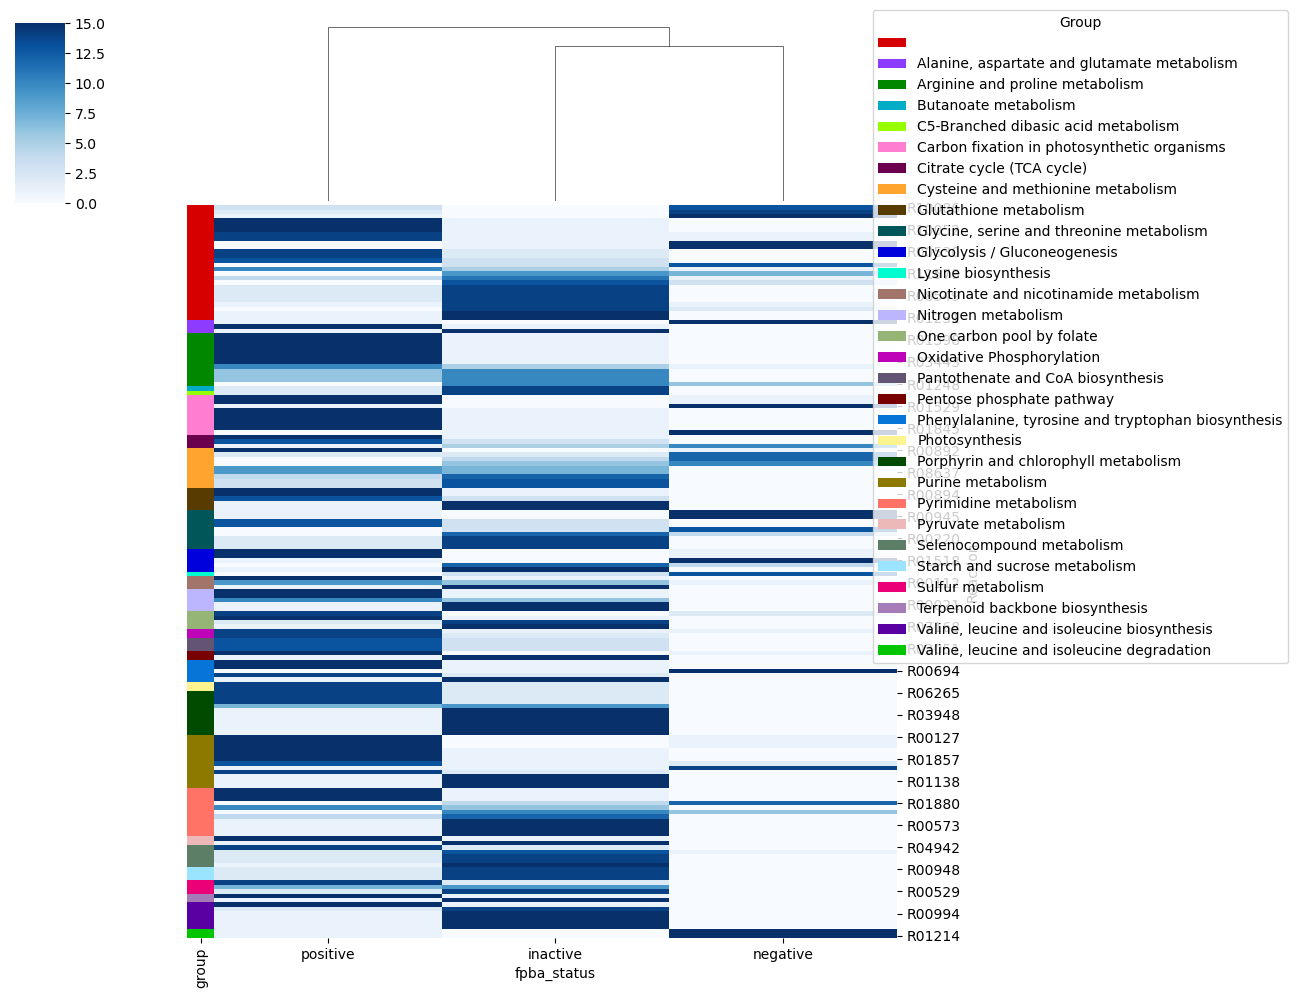

In [53]:
from matplotlib.patches import Patch

pdf = pfba_df.pivot_table(index='Reaction', columns='fpba_status', values='Uptake', aggfunc='nunique', fill_value=0)
pdf = pdf.loc[
    (pdf.inactive != 16) &
    (pdf.positive != 16) &
    (pdf.negative != 16) &
    ~pdf.index.to_series().str.contains('trans', case=False) & 
    ~pdf.index.to_series().isin(exchange_ids)     
]

cols = ['inactive', 'negative', 'positive',]
#cols = ['negative', 'positive',]
pdf['group'] = pdf.index.to_series().map(_get_group)
pdf = pdf.sort_values(['group'] + cols)
glist = pdf['group']

# glist = pdf.index.to_series().map(_get_group)
# glist = glist.sort_values()
# pdf = pdf.reindex(index=glist.index)

lut = dict(zip(glist.unique(), sns.color_palette(cc.glasbey, glist.nunique())))
sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut), row_cluster=False)
#sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut))
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Group',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [54]:
pdf.shape

(166, 4)

In [55]:
len(df_paths_list)

16

In [56]:
df_paths = pd.concat(df_paths_list)


In [57]:
#df_paths['Reactant'] = df_paths.Product.shift()
#df_paths.loc[df_paths.Index.isin([1]), 'Reactant'] = df_paths.loc[df_paths.Index.isin([1]), 'Product']

In [58]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(11,)

In [59]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#919191'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [60]:
df_paths.groupby(['Uptake'])['path_id'].nunique()

Uptake
AmmoniaEX        35
CyanateEX        61
GlutathioneEX    35
GlycineEX        34
GuanineEX        34
GuanosineEX      34
L_AlanineEX      34
L_ArginineEX     34
L_AspartateEX    34
L_CystineEX      34
L_GlutamateEX    34
L_GlutamineEX    34
L_LeucineEX      34
L_SerineEX       34
L_ValineEX       34
UreaEX           35
Name: path_id, dtype: int64

In [61]:
df_paths.columns


Index(['path_id', 'Index', 'Uptake', 'Reactant', 'Product', 'Reaction', 'Name',
       'Flux', 'Definition', 'Percent_Production', 'Group', 'group_color'],
      dtype='object')

In [62]:
df_paths.nunique()


path_id                 61
Index                   51
Uptake                  16
Reactant               111
Product                129
Reaction               175
Name                   174
Flux                  1120
Definition             175
Percent_Production     615
Group                   34
group_color             11
dtype: int64

In [63]:
df_paths.groupby(
    ['Reactant', 'Product', 'Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reactant,Product,Reaction,Name,Definition,0
210,NADH,NAD+,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],326
87,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],307
29,ADP,ATP,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],274
143,L-Cysteine,O-Acetyl-L-serine,R04859,R04859,H[c] + O_Acetyl_L_serine[c] + Thioredoxin[c] + Thiosulfate[c] <=> Acetate[c] + L_Cysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],267
150,L-Glutamate,L-Aspartate,R00355,L-Aspartate:2-oxoglutarate aminotransferase,L_Glutamate[c] + Oxaloacetate[c] --> 2_Oxoglutarate[c] + L_Aspartate[c],251
75,Ammonia,L-Glutamate,R10086,R10086,H2O[c] + L_Glutamate[c] + 2.0 Oxidized_ferredoxin[c] <=> 2_Oxoglutarate[c] + Ammonia[c] + 2.0 H[c] + 2.0 Reduced_ferredoxin[c],232
13,4-Phospho-L-aspartate,L-Aspartate 4-semialdehyde,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],230
130,L-Aspartate,4-Phospho-L-aspartate,R00480,ATP:L-aspartate 4-phosphotransferase,ATP[c] + L_Aspartate[c] <=> 4_Phospho_L_aspartate[c] + ADP[c],230
60,Acetyl_CoA[c],ADP,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],224
11,3-Phosphoadenylyl sulfate,Thioredoxin disulfide,R02021,"adenosine 3,5-bisphosphate,sulfite:oxidized-thioredoxin oxidoreductase",3_Phosphoadenylyl_sulfate[c] + Thioredoxin[c] --> Adenosine_3_5_bisphosphate[c] + Sulfite[c] + Thioredoxin_disulfide[c],216


In [64]:
df_paths.groupby(
    ['Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reaction,Name,Definition,0
23,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],533
150,R04859,R04859,H[c] + O_Acetyl_L_serine[c] + Thioredoxin[c] + Thiosulfate[c] <=> Acetate[c] + L_Cysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],482
113,R02021,"adenosine 3,5-bisphosphate,sulfite:oxidized-thioredoxin oxidoreductase",3_Phosphoadenylyl_sulfate[c] + Thioredoxin[c] --> Adenosine_3_5_bisphosphate[c] + Sulfite[c] + Thioredoxin_disulfide[c],435
50,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],368
167,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],326
13,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],274
43,R00586,acetyl-CoA:L-serine O-acetyltransferase,Acetyl_CoA[c] + L_Serine[c] <=> CoA[c] + O_Acetyl_L_serine[c],274
28,R00355,L-Aspartate:2-oxoglutarate aminotransferase,L_Glutamate[c] + Oxaloacetate[c] --> 2_Oxoglutarate[c] + L_Aspartate[c],251
115,R02026,O-acetyl-L-homoserine acetate-lyase (L-homocysteine forming),H[c] + O_Acetyl_L_homoserine[c] + Thioredoxin[c] + Thiosulfate[c] --> Acetate[c] + L_Homocysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],236
165,R10086,R10086,H2O[c] + L_Glutamate[c] + 2.0 Oxidized_ferredoxin[c] <=> 2_Oxoglutarate[c] + Ammonia[c] + 2.0 H[c] + 2.0 Reduced_ferredoxin[c],235


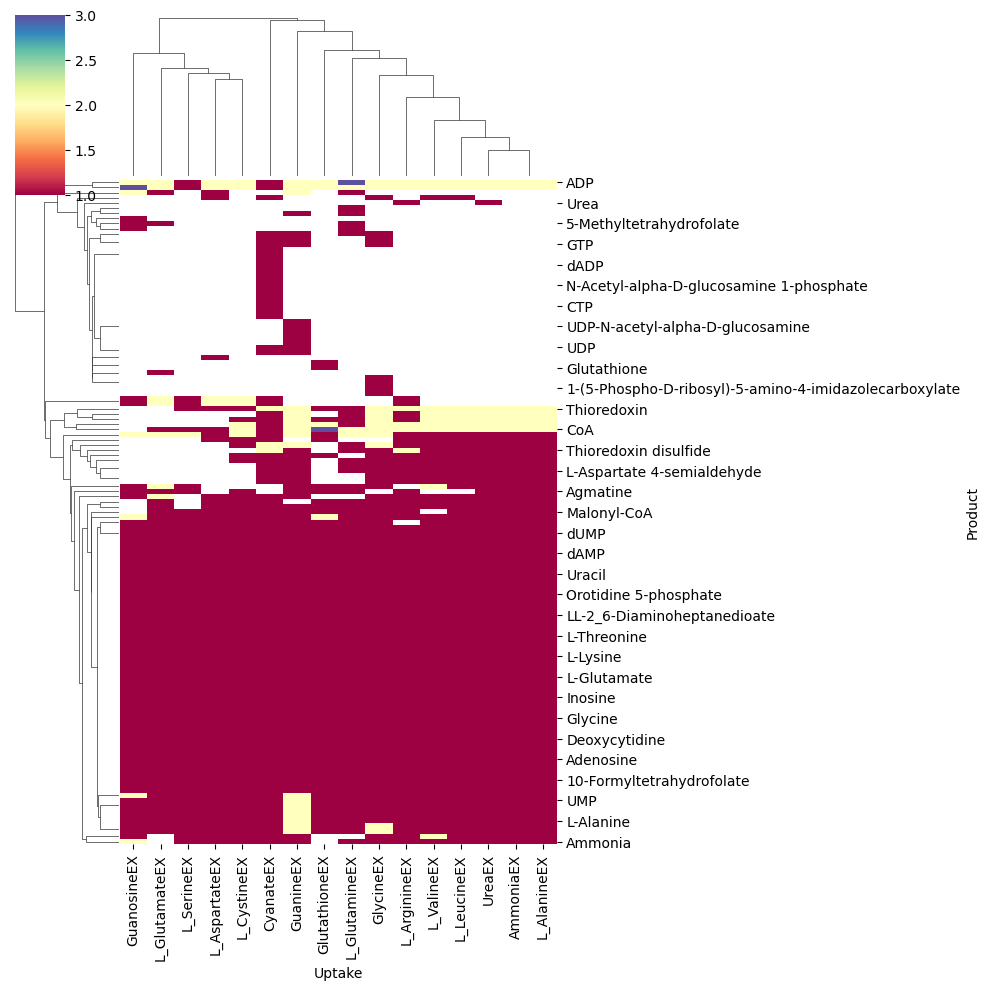

In [65]:
pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Reaction', aggfunc='nunique', fill_value=0)

sns.clustermap(pdf, mask=(pdf==0), cmap='Spectral')


In [66]:
df_paths.Reaction.str.contains('trans', case=False).sum()

574

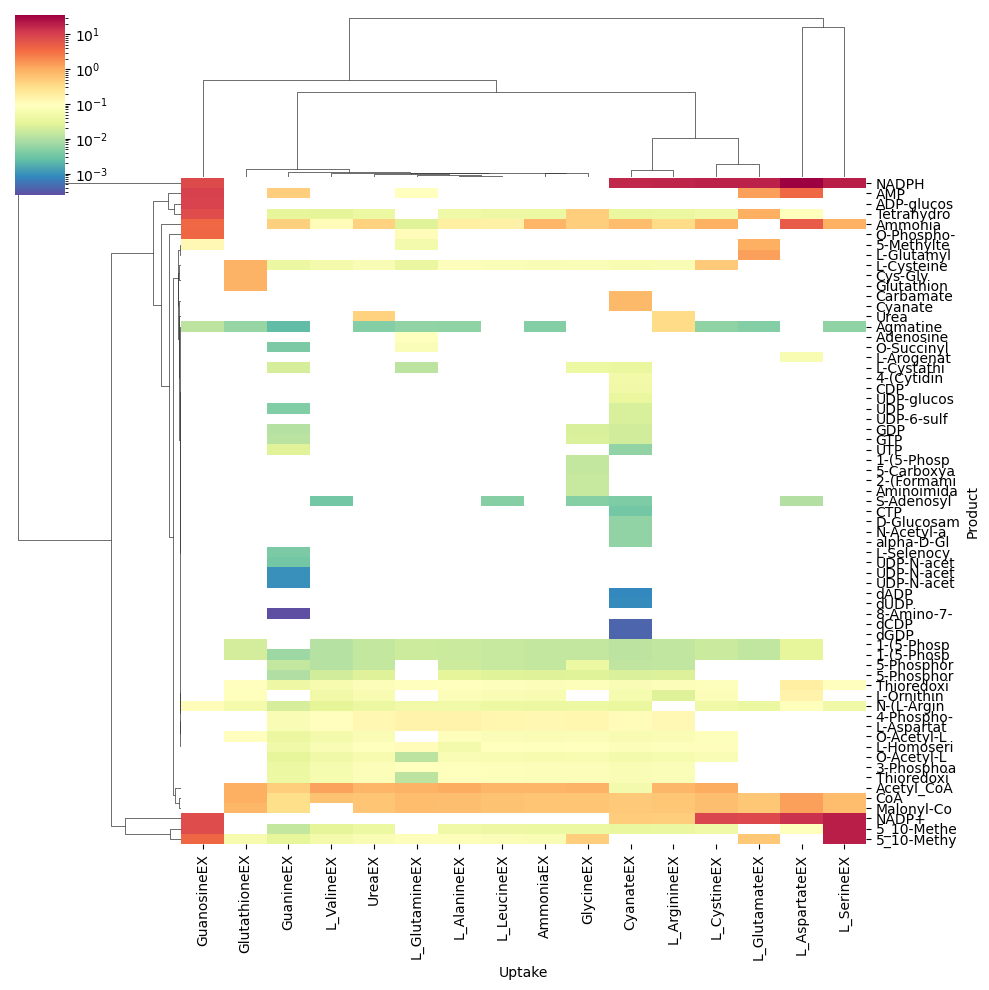

In [67]:

pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Flux', aggfunc='max', fill_value=0)
sel = (pdf == 0).sum(axis=1) > 0

sns.clustermap(
    pdf.loc[sel], mask=(pdf.loc[sel]==0), cmap='Spectral_r', norm=LogNorm(),
    yticklabels= pdf.loc[sel].index.str.slice(0, 10),
    #figsize=(10,20),

              )

In [68]:
pdf

Uptake,AmmoniaEX,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Product,,,,,,,,,,,,,,,,
(S)-Dihydroorotate,0.008946,0.008011,0.012469,0.009234,0.004782,0.025009,0.010581,0.008613,0.020139,0.010581,0.008837,0.011078,0.009449,0.010810,0.006808,0.008946
1-(5-Phospho-D-ribosyl)-5-amino-4-imidazolecarboxylate,0.000000,0.000000,0.000000,0.014551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1-(5-Phosphoribosyl)-5-amino-4-(N-succinocarboxamide)-imidazole,0.014098,0.012625,0.019650,0.014551,0.000000,0.000000,0.016674,0.013573,0.031737,0.016674,0.013926,0.017457,0.014891,0.000000,0.010729,0.014098
1-(5-Phosphoribosyl)-5-amino-4-imidazolecarboxamide,0.014098,0.012625,0.019650,0.014551,0.006824,0.000000,0.016674,0.013573,0.031737,0.016674,0.013926,0.017457,0.014891,0.000000,0.010729,0.014098
1-(5-Phosphoribosyl)-5-formamido-4-imidazolecarboxamide,0.026863,0.024056,0.037442,0.027726,0.011031,0.057688,0.031771,0.025861,0.060472,0.031771,0.026535,0.033263,0.028373,0.032458,0.020444,0.026863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dGMP,0.000026,0.000023,0.000036,0.000027,0.000014,0.000072,0.000030,0.000025,0.000058,0.000030,0.000025,0.000032,0.000027,0.000031,0.000020,0.000026
dTMP,0.000949,0.000850,0.001323,0.000980,0.000508,0.002654,0.001123,0.000914,0.002137,0.001123,0.000938,0.001176,0.001003,0.001147,0.000723,0.000949
dUDP,0.000000,0.000877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [69]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=1000, columns='Flux').Reaction.unique()

In [70]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=300, columns='Flux').Reaction.unique()

In [71]:
(df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].groupby('Product').Uptake.nunique() > 1).sum()

99

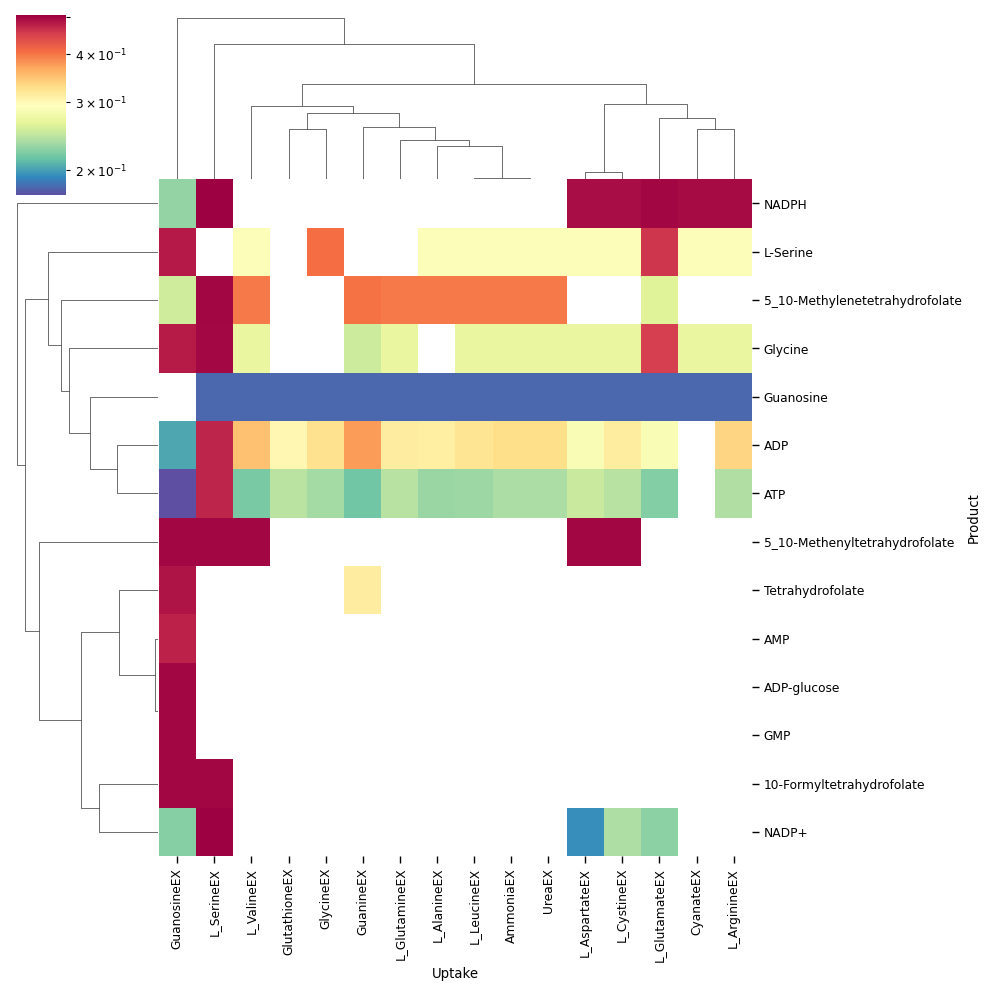

In [72]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)].pivot_table(columns='Uptake', index=['Product',#'Name'
                                                                                              ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', norm=LogNorm(),
    figsize=(10,10),
    yticklabels= pdf.index.str.slice(0, 30),

              )

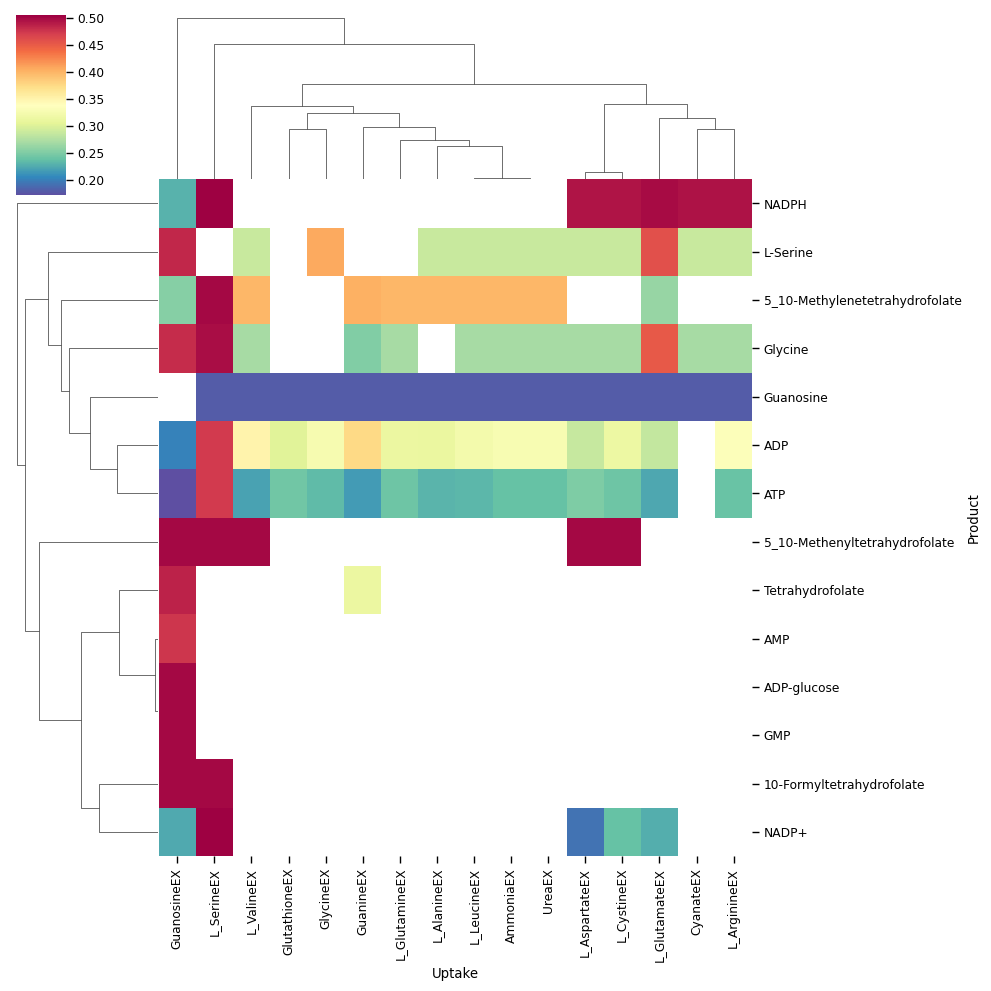

In [73]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', 
                                index=['Product',#'Name'
                                      ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    figsize=(10,10),
    #yticklabels= pdf.index.str.slice(0, 30),

              )

In [74]:
group_colors

{'Lysine biosynthesis': '#8dd3c7',
 'Terpenoid backbone biosynthesis': '#ffffb3',
 'Alanine, aspartate and glutamate metabolism': '#bebada',
 'Pyrimidine metabolism': '#fb8072',
 'Purine metabolism': '#80b1d3',
 'Porphyrin and chlorophyll metabolism': '#fdb462',
 'Phenylalanine, tyrosine and tryptophan biosynthesis': '#b3de69',
 'Valine, leucine and isoleucine degradation': '#fccde5',
 'Nitrogen metabolism': '#d9d9d9',
 'Histidine metabolism': '#bc80bd',
 'Other': '#919191'}

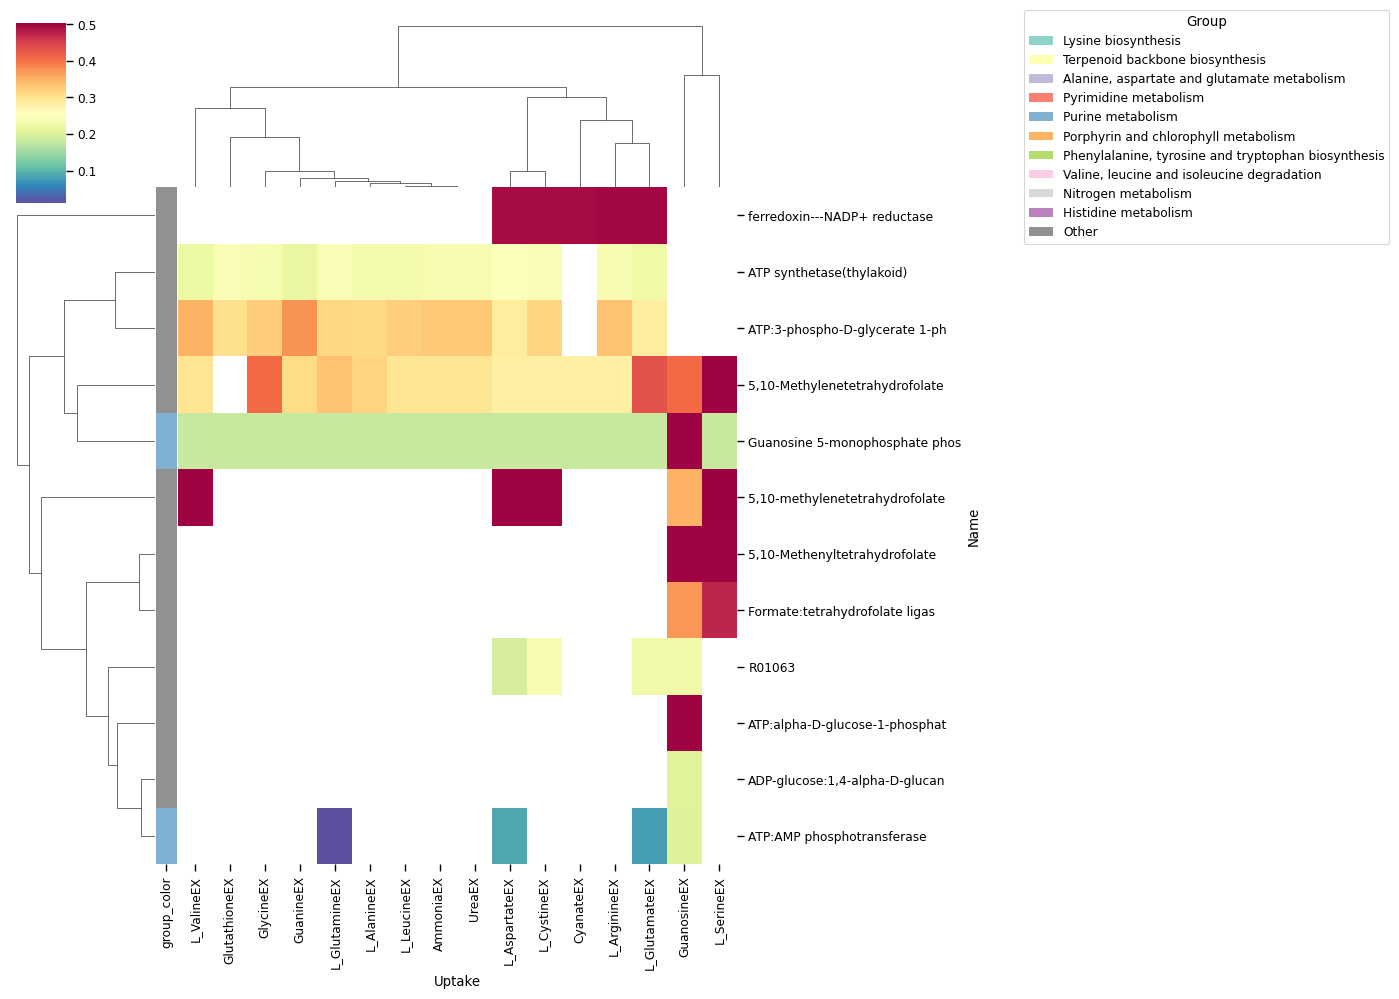

In [75]:
from matplotlib.patches import Patch

pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', index=[#'Product',
    'Name'], values='Percent_Production', aggfunc='mean', fill_value=0)
row_colors = df_paths.groupby('Name').group_color.first()

sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    yticklabels= pdf.index.str.slice(0, 30),
    row_colors=row_colors[pdf.index]

              )

handles = [Patch(facecolor=group_colors[name]) for name in group_colors]
plt.legend(handles, group_colors, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


In [76]:
df_paths

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,group_color
0,1,1,GuanosineEX,Guanosine[e],Guanosine,Trans_Guanosine,Trans_Guanosine,10.557712,Guanosine[e] <=> Guanosine[c],0.499994,,#919191
1,1,2,GuanosineEX,Guanosine,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,#80b1d3
2,1,3,GuanosineEX,GMP,AMP,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.110290,Purine metabolism,#80b1d3
3,1,4,GuanosineEX,AMP,ATP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,8.126892,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.140829,Pentose phosphate pathway,#919191
4,1,5,GuanosineEX,ATP,ADP-glucose,R00948,ATP:alpha-D-glucose-1-phosphate adenylyltransferase,9.488995,ATP[c] + D_Glucose_1_phosphate[c] --> ADP_glucose[c] + Diphosphate[c],0.500000,Starch and sucrose metabolism,#919191
...,...,...,...,...,...,...,...,...,...,...,...,...
850,34,19,GuanineEX,Acetyl_CoA[c],ADP,R00742,Acetyl-CoA:carbon-dioxide ligase,0.310416,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],0.012718,Pyruvate metabolism,#919191
851,34,20,GuanineEX,ADP,ATP,R00086th,ATP synthetase(thylakoid),5.506463,3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],0.217405,Photosynthesis,#919191
852,34,21,GuanineEX,ATP,AMP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,0.464833,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.412005,Pentose phosphate pathway,#919191
853,34,22,GuanineEX,AMP,Xanthosine 5-phosphate,R01230,Xanthosine-5-phosphate:ammonia ligase,0.440509,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.500000,Purine metabolism,#80b1d3


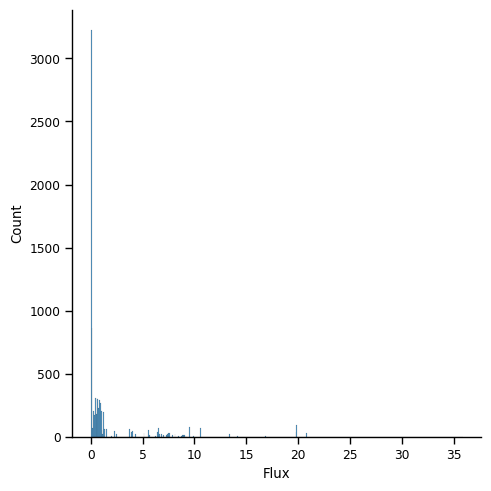

In [77]:
sns.displot(df_paths.Flux)

In [78]:
#df_paths['orig_flux'] = df_paths['Flux']
df_paths.loc[df_paths['Flux'] > 2, 'Flux'] = 2

In [79]:
df_reaction2FC = df_paths.copy()
df_reaction2FC['gid'] = df_reaction2FC.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])
df_reaction2FC =df_reaction2FC.explode(column='gid')

In [80]:
df_reaction2FC = df_reaction2FC[['Reaction', 'gid']].drop_duplicates().dropna()

In [81]:
dpath = os.path.join('data', 'RNASEQ')
deseq_df = pd.merge(pd.read_csv(os.path.join(dpath, 'MED4_DE_genes_DESEQ_wKEGG.csv')),
         pd.read_csv(os.path.join(dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'gid']),
         on='gene_id'
        )

In [82]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id', 'gid'],
      dtype='object')

In [83]:
cols = ['gid', 'gene_id', 'gene', 'product', 'status', 'baseMean', 'log2FoldChange',  'padj',]
df_reaction2FC = pd.merge(df_reaction2FC, deseq_df[cols], how='left', on='gid', 
         suffixes=['', '_deseq'])

In [84]:
df_reaction2FC['absFC'] = np.abs(df_reaction2FC.log2FoldChange)
df_reaction2FC = df_reaction2FC.sort_values('absFC', ascending=False).drop_duplicates(subset='Reaction', keep='first')

In [85]:
df_paths = pd.merge(df_paths, df_reaction2FC, on='Reaction', how='left')

In [139]:
depro_df = pd.merge(pd.read_csv(os.path.join(dpath, 'PRO_CC_DE.csv')),
         pd.read_csv(os.path.join(dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'gid']),
         on='gene_id'
        )


In [140]:
depro_df = depro_df.loc[depro_df.contrast == 'Clongterm - C1'] # logFC

In [144]:
df_Preaction2FC = df_paths.copy()
df_Preaction2FC['gid'] = df_Preaction2FC.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])
df_Preaction2FC =df_Preaction2FC.explode(column='gid')
df_Preaction2FC = df_Preaction2FC[['Reaction', 'gid']].drop_duplicates().dropna()

In [145]:
cols = ['gid', 'logFC',]
df_Preaction2FC = pd.merge(df_Preaction2FC, depro_df[cols], how='left', on='gid', 
         suffixes=['', '_prot'])

In [146]:
df_Preaction2FC['absFC'] = np.abs(df_Preaction2FC.logFC)
df_Preaction2FC = df_Preaction2FC.sort_values('absFC', ascending=False).drop_duplicates(subset='Reaction', keep='first')

In [147]:
df_paths = pd.merge(df_paths, df_Preaction2FC, on='Reaction', how='left')

In [148]:
df_paths.head()

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,...,baseMean,log2FoldChange,padj,absFC_x,Line_width,Source,Target,gid_y,logFC,absFC_y
0,1,1,GuanosineEX,Guanosine[e],Guanosine,Trans_Guanosine,Trans_Guanosine,2.0,Guanosine[e] <=> Guanosine[c],0.499994,...,NaN,NaN,NaN,NaN,7.0,Guanosine[e],Guanosine,NaN,NaN,NaN
1,1,2,GuanosineEX,Guanosine,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,2.0,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,...,317.510916,0.984481,0.000150,0.984481,7.0,Guanosine,GMP,PMM1271,0.357745,0.357745
2,1,3,GuanosineEX,GMP,AMP,R01230,Xanthosine-5-phosphate:ammonia ligase,2.0,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.110290,...,667.832767,-0.167408,0.566051,0.167408,7.0,GMP,AMP,PMM0037,0.244350,0.244350
3,1,4,GuanosineEX,AMP,ATP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,2.0,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.140829,...,3246.525301,0.454870,0.113961,0.454870,7.0,AMP,ATP,PMM1080,0.079644,0.079644
4,1,5,GuanosineEX,ATP,ADP-glucose,R00948,ATP:alpha-D-glucose-1-phosphate adenylyltransferase,2.0,ATP[c] + D_Glucose_1_phosphate[c] --> ADP_glucose[c] + Diphosphate[c],0.500000,...,2382.102174,-0.383249,0.250134,0.383249,7.0,ATP,ADP-glucose,PMM0769,0.032848,0.032848


In [149]:
#df_paths['weight'] = df_paths['Flux']
# from Daniel S. notebook
thickness_factor = 7
df_paths['Line_width'] = thickness_factor*np.abs(df_paths['Flux']) /max(np.abs(df_paths['Flux'])) # Computes normalized flux vector for drawing network
#df_paths['Line_width'] = (np.abs(df_paths['Flux']) +0.1) *10


G = nx.from_pandas_edgelist(df_paths, source='Reactant', target='Product', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')

In [150]:
df_paths['Source'] = df_paths['Reactant']
df_paths['Target'] = df_paths['Product']


In [151]:
df_paths.groupby(['Reaction', 'Group']).size().reset_index().Group.value_counts().head(10)

Purine metabolism                              24
Pyrimidine metabolism                          22
                                               19
Glycine, serine and threonine metabolism       14
Transport                                      13
Cysteine and methionine metabolism             13
Arginine and proline metabolism                 7
Nitrogen metabolism                             5
One carbon pool by folate                       5
Alanine, aspartate and glutamate metabolism     5
Name: Group, dtype: int64

In [152]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(11,)

In [153]:
df_paths.head()

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,...,baseMean,log2FoldChange,padj,absFC_x,Line_width,Source,Target,gid_y,logFC,absFC_y
0,1,1,GuanosineEX,Guanosine[e],Guanosine,Trans_Guanosine,Trans_Guanosine,2.0,Guanosine[e] <=> Guanosine[c],0.499994,...,NaN,NaN,NaN,NaN,7.0,Guanosine[e],Guanosine,NaN,NaN,NaN
1,1,2,GuanosineEX,Guanosine,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,2.0,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,...,317.510916,0.984481,0.000150,0.984481,7.0,Guanosine,GMP,PMM1271,0.357745,0.357745
2,1,3,GuanosineEX,GMP,AMP,R01230,Xanthosine-5-phosphate:ammonia ligase,2.0,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.110290,...,667.832767,-0.167408,0.566051,0.167408,7.0,GMP,AMP,PMM0037,0.244350,0.244350
3,1,4,GuanosineEX,AMP,ATP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,2.0,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.140829,...,3246.525301,0.454870,0.113961,0.454870,7.0,AMP,ATP,PMM1080,0.079644,0.079644
4,1,5,GuanosineEX,ATP,ADP-glucose,R00948,ATP:alpha-D-glucose-1-phosphate adenylyltransferase,2.0,ATP[c] + D_Glucose_1_phosphate[c] --> ADP_glucose[c] + Diphosphate[c],0.500000,...,2382.102174,-0.383249,0.250134,0.383249,7.0,ATP,ADP-glucose,PMM0769,0.032848,0.032848


In [154]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#919191'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [167]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine, PointDrawTool
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
from bokeh.transform import linear_cmap, log_cmap
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot(df_paths, met1, FC_col='log2FoldChange'):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.loc[df_paths.Uptake.isin([met1])].copy()
    thickness_factor = 7
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 0.3) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network

    met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin([met_name]),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.node.isin([met_name]) & attr_df.label.isna(),'label'] = met_name

    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=500, height=500, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title=met_name)

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color=linear_cmap(FC_col, "RdBu8", -2, 2), line_alpha=0.8, line_width='Line_width1')
    #"Turbo256"
    #graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)
    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
        ('Flux', '@Flux'),
        ('log2FoldChange RNA', '@log2FoldChange'),
        ('log2FoldChange Prot', '@logFC'),
        
        
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool(),
        #PointDrawTool(renderers = [graph.node_renderer], empty_value = 'black')
                  )
    return plot



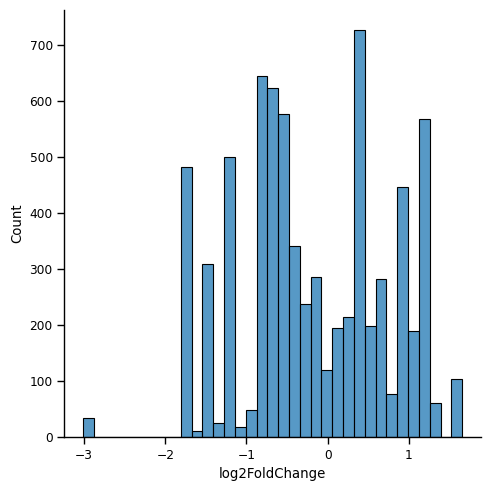

In [168]:
sns.displot(df_paths.log2FoldChange)

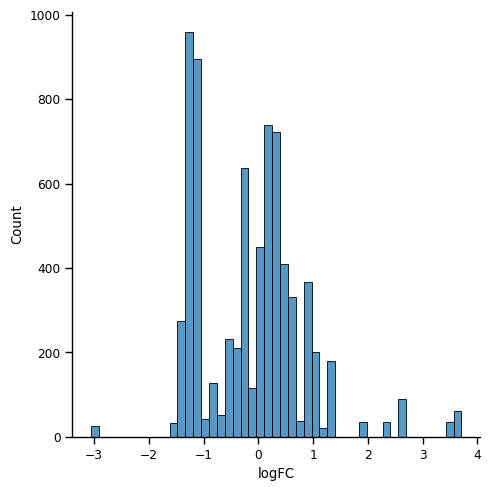

In [169]:
sns.displot(df_paths.logFC)

In [170]:
from bokeh.plotting import figure
from bokeh import events
from bokeh.models import CustomJS, Div, Button
from bokeh.layouts import column, row

m = 'GlycineEX'
p = _create_plot(df_paths, m) 

# item_list = 
# legend = Legend(items=[
#     LegendItem(label="orange", renderers=[r], index=0),
#     LegendItem(label="red", renderers=[r], index=1),
# ])
# p.add_layout(legend)
# div = Div(width=400)
# layout = column(p, div)

# p.js_on_event(events.SelectionGeometry, CustomJS(args=dict(div=div), code="""
# div.text = "Selection! <p> <p>" + JSON.stringify(cb_obj.geometry, undefined, 2);
# """))

# show(layout)
show(p)

In [171]:
from bokeh.io import output_file, show
output_file("aa_production.html")
plots = [_create_plot(df_paths, m) for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

In [172]:
from bokeh.io import output_file, show
output_file("aa_production_proteome.html")
plots = [_create_plot(df_paths, m, FC_col='logFC') for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

In [120]:
df_paths.Target.value_counts().head(40)

L-Glutamate                                                   410
ATP                                                           398
ADP                                                           383
NADH                                                          342
NAD+                                                          342
CoA                                                           319
L-Aspartate                                                   297
Ammonia                                                       283
L-Cysteine                                                    282
Acetyl_CoA[c]                                                 282
O-Acetyl-L-serine                                             267
L-Homoserine                                                  232
Thioredoxin                                                   231
L-Aspartate 4-semialdehyde                                    230
4-Phospho-L-aspartate                                         230
Thioredoxi

In [98]:
df_paths.to_excel('MED4_paths_to_ammonia.xlsx')

In [ ]:
df_paths.head()

In [ ]:
colors = all_palettes['Category20'][16]

In [ ]:
sns.color_palette(colors)

In [ ]:
lut = dict(zip(sorted(df_paths.Uptake.unique()), colors))

In [ ]:
list(lut)

In [ ]:
df_paths['uptake_color'] = df_paths.Uptake.map(lut)

In [ ]:
df_paths[['Uptake','Reaction','uptake_color']].to_excel('amino_uptake_reactions_kegg.xlsx')

In [ ]:
all_aa_reactions_df = pfba_df.loc[pfba_df.Reaction.isin(df_paths.Reaction) & np.abs(pfba_df.fluxes) > 1e-5].copy()

In [ ]:
all_aa_reactions_df['uptake_color'] = all_aa_reactions_df.Uptake.map(lut)

In [ ]:
all_aa_reactions_df['gid'] = all_aa_reactions_df.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])
all_aa_reactions_wgenes_df = all_aa_reactions_df.explode(column='gid')

In [ ]:
all_aa_reactions_wgenes_df

In [ ]:
all_aa_reactions_df[['Reaction','uptake_color']].to_excel('amino_uptake_all_reactions_kegg.xlsx', index=False)

In [ ]:
all_aa_reactions_wgenes_df[['gid','uptake_color']].dropna().drop_duplicates().to_excel('amino_uptake_all_genes_kegg.xlsx', index=False)

In [ ]:
all_aa_reactions_wgenes_df = all_aa_reactions_wgenes_df.dropna(subset=['gid'])

In [ ]:
all_aa_reactions_wgenes_df.dropna(subset='gid').pivot_table(
    index=['gid'], columns='Uptake', values='fluxes', aggfunc='max', fill_value=0
    ).to_csv('amino_uptake_all_genes_biocyc.csv', sep='\t')


In [ ]:
from matplotlib.patches import Patch

pdf = all_aa_reactions_wgenes_df.dropna(subset='gid').pivot_table(
    index=['Group', 'gid'], columns='Uptake', values='fluxes', aggfunc='max', fill_value=0)

cols = pdf.columns.to_list()
glist = pdf.index.get_level_values(0).to_series()

mask = np.abs(pdf) < 1e-5
lut = dict(zip(glist.unique(), sns.color_palette(cc.glasbey, glist.nunique())))
sns.clustermap(np.abs(pdf), cmap='viridis', 
               row_colors=glist.map(lut).values, 
               row_cluster=False, #center=0, 
               mask=mask,
                   yticklabels=False, #vmax=5, vmin=-5,
            dendrogram_ratio=0.1,
               norm=LogNorm(),
              )
#sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut))
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [ ]:
df_paths['Source1'] = df_paths['Source']
df_paths.loc[df_paths.Index == 1, 'Source1'] = df_paths.loc[df_paths.Index == 1, 'Source1']+ '_e'

In [ ]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    #df = df_paths.loc[df_paths.Uptake.isin([met1])]
    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df = df_paths
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source1', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    aa_names_so = [i.name+ '_e' for i in amino_acid_metabolites]
    
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin(aa_names_so),'Type'] = 'Uptake'

    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','Other'], (list(all_palettes['Category10'][3]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=600, height=600, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               #title=met_name
               )

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8) #, line_width='Line_width')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [ ]:
p = _create_plot_all(df_paths)
show(p)

In [ ]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.copy()
    thickness_factor = 1
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    lwidthmap = df.groupby('Reaction').Uptake.nunique()
    df['Line_width1'] = thickness_factor*np.sqrt(df['Reaction'].map(lwidthmap))

    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.str.endswith('[e]'),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'label'] = attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'node']

    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=1000, height=1000, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title='all uptake')

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [ ]:
output_file("aa_production_all.html")
p = _create_plot_all(df_paths)

show(p)

In [ ]:
df_paths.to_excel('paths_to_aa_dna.xlsx')

In [ ]:
df = df_paths.copy()

#met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'

G = nx.from_pandas_edgelist(df, 
                            source='Source', target='Target', edge_attr=True, 
                        create_using=nx.MultiDiGraph, edge_key='Reaction')

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities
clusters = greedy_modularity_communities(G)
#clusters = louvain_communities(G)
cluster_map = {n: cluster_id for cluster_id, cluster_set in enumerate(clusters, start=1) for n in cluster_set}

In [ ]:
target2group_df = df_paths.groupby(['Target', 'Group'])['Uptake'].nunique().reset_index()
target2group_df['cluster_id'] = target2group_df['Target'].map(cluster_map)

In [ ]:
target2group_df.groupby(['cluster_id', 'Group', ]).size().tail(50)

In [ ]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
import pygraphviz
#tools='pan,wheel_zoom,box_select'
#def _layout_func(G, prog="dot", args=""):
def _layout_func(G, prog="twopi", args=""):
    A = nx.nx_agraph.to_agraph(G)
    A.node_attr.update(fixedsize="true", label='', shape='point') #, ranksep="0.1")
    A.graph_attr.update(#ranksep="0.1", 
        landscape="true", diredgeconstraints='true', mode="ipsep")

    #A.fixedsize=True
    #for cluster_id, cluster_set in enumerate(clusters, start=1):
    #   B = A.add_subgraph(cluster_set, name=f"cluster_{cluster_id}", rank='min')
    A.layout(prog=prog, args=args)
    display(A)
    node_pos = {}
    for n in G:
        node = pygraphviz.Node(A, n)
        try:
            xs = node.attr["pos"].split(",")
            node_pos[n] = tuple(float(x) for x in xs)
        except:
            print("no position for node", n)
            node_pos[n] = (0.0, 0.0)
    return node_pos

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.copy()
    thickness_factor = 1
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    lwidthmap = df.groupby('Reaction').Uptake.nunique()
    df['Line_width1'] = thickness_factor*np.sqrt(df['Reaction'].map(lwidthmap))

    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.str.endswith('[e]'),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'label'] = attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'node']

    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    attr_df['cluster_id'] = attr_df['node'].map(cluster_map)
    #attr_df['node_color'] = attr_df['cluster_id'].map(dict(zip(attr_df['cluster_id'].unique(), (list(all_palettes['Category20'][16])))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=1000, height=1000, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title='all uptake')

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    graph = from_networkx(G, _layout_func, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [ ]:
#output_file("aa_production_all.html")
p = _create_plot_all(df_paths)

show(p)

In [ ]:
def _gen_layout_dot(G, prog="dot", args=""):
    A = nx.nx_agraph.to_agraph(G)
    A.node_attr.update(fixedsize="true", label='', shape='point') #, ranksep="0.1")
    A.graph_attr.update(#ranksep="0.1", 
        landscape="true", diredgeconstraints='true', mode="ipsep")

    #A.fixedsize=True
    #for cluster_id, cluster_set in enumerate(clusters, start=1):
    #   B = A.add_subgraph(cluster_set, name=f"cluster_{cluster_id}", rank='min')
    A.layout(prog=prog, args=args)
    #display(A)
    return (A)



def _create_layout(df_paths):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.copy()
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')

    return _gen_layout_dot(G, prog="dot")

Agraph_with_layout = _create_layout(df_paths)

def _layout_func(G):
    node_pos = {}
    for n in G:
        try:
            node = pygraphviz.Node(Agraph_with_layout, n)
            xs = node.attr["pos"].split(",")
            node_pos[n] = tuple(float(x) for x in xs)
        except:
            print("no position for node", n)
            node_pos[n] = (0.0, 0.0)
    return node_pos


In [ ]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
    

def _create_plot(df_paths, met1):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.loc[df_paths.Uptake.isin([met1])].copy()
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    thickness_factor = 10
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 1) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network

    met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin([met_name]),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.node.isin([met_name]) & attr_df.label.isna(),'label'] = met_name
    attr_df['cluster_id'] = attr_df['node'].map(cluster_map)
    #attr_df['node_color'] = attr_df['cluster_id'].map(dict(zip(attr_df['cluster_id'].unique(), (list(all_palettes['Category20'][16])))))
    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=500, height=500, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title=met_name)

    # Create a Bokeh graph from the NetworkX input using precomputed layout
    graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [ ]:
from bokeh.plotting import figure
from bokeh import events
from bokeh.models import CustomJS, Div, Button
from bokeh.layouts import column, row

m = 'GlycineEX'
p = _create_plot(df_paths, m) 

# item_list = 
# legend = Legend(items=[
#     LegendItem(label="orange", renderers=[r], index=0),
#     LegendItem(label="red", renderers=[r], index=1),
# ])
# p.add_layout(legend)
# div = Div(width=400)
# layout = column(p, div)

# p.js_on_event(events.SelectionGeometry, CustomJS(args=dict(div=div), code="""
# div.text = "Selection! <p> <p>" + JSON.stringify(cb_obj.geometry, undefined, 2);
# """))

# show(layout)
show(p)

In [ ]:
from bokeh.io import output_file, show
output_file("aa_production.html")
plots = [_create_plot(df_paths, m) for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

# indicators

In [ ]:
cols = ['Uptake', 'Reactant', 'Product', 'Reaction']
cols = ['Uptake', 'Reaction']

df_paths[['Uptake', 'Reaction']].drop_duplicates(ignore_index=True).groupby('Uptake').size()

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
reatcion_per_uptake_df = df_paths.pivot_table(index='Uptake', columns='Reaction', values='Product', aggfunc=lambda x: True, fill_value=False)
jac_sim = 1 - pairwise_distances(reatcion_per_uptake_df.values, metric = "jaccard")
# optionally convert it to a DataFrame
jac_sim = pd.DataFrame(jac_sim, index=reatcion_per_uptake_df.index, columns=reatcion_per_uptake_df.index)

In [ ]:
sns.clustermap(jac_sim, cmap='coolwarm')
plt.suptitle('jaccard similarity between uptake reaction sets', y=1)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

linkage_matrix = linkage(squareform(1 - jac_sim, "single"))
dendrogram(linkage_matrix, labels=jac_sim.columns, orientation='right')
plt.title("MED4 clustering of uptake metabolites based on overlap between the reaction sets required for growth")
#plt.xticks(rotation=90)
plt.show()


In [ ]:
df_paths_w_genes = df_paths.copy()
df_paths_w_genes['gid'] = df_paths_w_genes.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])
df_paths_w_genes =df_paths_w_genes.explode(column='gid')

In [ ]:
cols = [
    'Uptake', 'Reactant', 'Product', 'Reaction', 'Name',
       'Flux', 'Definition', 'Percent_Production', 'Group', 'gid']

df_paths_w_genes = df_paths_w_genes[cols].drop_duplicates()

In [ ]:
dpath = os.path.join('data', 'RNASEQ')
deseq_df = pd.merge(pd.read_csv(os.path.join(dpath, 'MED4_DE_genes_DESEQ_wKEGG.csv')),
         pd.read_csv(os.path.join(dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'gid']),
         on='gene_id'
        )

In [ ]:
pd.read_excel(os.path.join('data', 'PRO_N_sources.xlsx'), sheet_name=None).keys()

In [ ]:
gene_knockout_df = pd.read_excel(os.path.join('data', 'PRO_N_sources.xlsx'), sheet_name='gene_knockout_uptake')


In [ ]:
cols = ['uptake', 'gid', 'status']
gene_knockout_df = gene_knockout_df.loc[gene_knockout_df.status.isin(['infeasible'])].drop_duplicates(subset=cols)

gene_knockout_df.loc[gene_knockout_df.status.isin(['infeasible']),cols].drop_duplicates()
df_paths_w_genes = pd.merge(df_paths_w_genes, gene_knockout_df.loc[gene_knockout_df.status.isin(['infeasible']),cols].drop_duplicates(), 
         right_on =['uptake', 'gid'], 
         left_on =['Uptake', 'gid'], 
         how = 'left')

In [ ]:
deseq_df.columns

In [ ]:
cols = ['gid', 'gene_id', 'gene', 'product', 'status', 'baseMean', 'log2FoldChange',  'padj',]
df_paths_w_genes = pd.merge(df_paths_w_genes, deseq_df[cols], how='left', on='gid', 
         suffixes=['', '_deseq'])

In [ ]:
#', '.join(
    
df_paths_w_genes.pivot_table(columns='Uptake', index='Group', values='Reaction', aggfunc='nunique', fill_value=0
                            ).mean(axis=1).sort_values(ascending=False).index.to_list()

In [ ]:
paths_for_grouping = [
'Purine metabolism',
 'Pyrimidine metabolism',
 'Cysteine and methionine metabolism',
 'Glycine, serine and threonine metabolism',
 'Arginine and proline metabolism',
 'Alanine, aspartate and glutamate metabolism',
 'Lysine biosynthesis',
 'Valine, leucine and isoleucine degradation',
 'Terpenoid backbone biosynthesis',
 'Phenylalanine, tyrosine and tryptophan biosynthesis',
 'Nitrogen metabolism',
 'Porphyrin and chlorophyll metabolism',
 'Sulfur metabolism',
 'Histidine metabolism',
 'Pyruvate metabolism',
 'Citrate cycle (TCA cycle)',
 'Fatty acid biosynthesis',
 'Photosynthesis',
 'Glycolysis / Gluconeogenesis',
 'Transport',
 'One carbon pool by folate',
 'Amino sugar and nucleotide sugar metabolism',
 'Oxidative Phosphorylation',
 'Starch and sucrose metabolism',
 'Nicotinate and nicotinamide metabolism',
 'Pentose phosphate pathway',
 'Glutathione metabolism',
 'Biotin metabolism',
 'Glycerolipid metabolism',
 'Biomass Formation',
 'D-Glutamine and D-glutamate metabolism',
 'Valine, leucine and isoleucine biosynthesis',
    
       'Nitrogen metabolism',    
       'Phenylalanine, tyrosine and tryptophan biosynthesis',
       'Glycine, serine and threonine metabolism',
       'Fatty acid biosynthesis',
       'Cysteine and methionine metabolism',
       'Alanine, aspartate and glutamate metabolism',
       'Valine, leucine and isoleucine biosynthesis',
       'Amino sugar and nucleotide sugar metabolism',
       'Photosynthesis',
       'Carbon fixation in photosynthetic organisms',
       'Porphyrin metabolism',
       'Purine metabolism',
       'Transporters',
       'Pyrimidine metabolism',
       'Pantothenate and CoA biosynthesis',
       'Folate biosynthesis',
       'Histidine metabolism',
       'Terpenoid backbone biosynthesis',
       'Biotin metabolism',
       'Nicotinate and nicotinamide metabolism',
       'Pyruvate metabolism',
       'Thiamine metabolism',
       'Lysine biosynthesis',
       'Lipopolysaccharide biosynthesis',
       'Riboflavin metabolism',
       'Carotenoid biosynthesis',
       'Arginine and proline metabolism',
       #'Glycerolipid metabolism',
       'Carbon fixation pathways in prokaryotes',
       #'Glyoxylate and dicarboxylate metabolism',
       'Oxidative phosphorylation',
       'DNA repair and recombination proteins',
]
gene_knockout_df['Group'] = np.NaN
for i in paths_for_grouping:
    gene_knockout_df.loc[gene_knockout_df['Group'].isna() & gene_knockout_df.path.str.contains(i, regex=False), 'Group'] = i
gene_knockout_df.loc[gene_knockout_df['Group'].isna(), 'Group'] = 'Other'

In [ ]:
df_paths_w_genes.loc[df_paths_w_genes.Group.isin(['Oxidative Phosphorylation']), 'Group'] = 'Oxidative phosphorylation'
df_paths_w_genes.loc[df_paths_w_genes.Group.isin(['Porphyrin and chlorophyll metabolism']), 'Group'] = 'Porphyrin metabolism'
df_paths_w_genes.loc[df_paths_w_genes.Group.isin(['']), 'Group'] = 'Other'


In [ ]:
kegg_df = pd.read_csv('~/work/CC1A3/genomes/kegg_pathways.csv')
kegg_df['Group'] = kegg_df['path'].str.extract(r'\d+ (.*) \[.*')
kegg_df['Module'] = kegg_df['sub'].str.extract(r'\d+ (.*)')
df_group2module = kegg_df.loc[
    kegg_df.Group.isin(gene_knockout_df.Group) |
    kegg_df.Group.isin(df_paths_w_genes.Group) 
].groupby(['Module', 'Group']).size().reset_index()

In [ ]:
new_group2module = pd.DataFrame.from_records([
    dict(Module='Amino acid metabolism', Group='D-Glutamine and D-glutamate metabolism'),
    dict(Module='Transport', Group='Transport'),
    dict(Module='Other', Group='Biomass Formation'),
    dict(Module='Other', Group='Other'),
])

df_group2module = pd.concat([df_group2module, new_group2module], ignore_index=True)

In [ ]:
gene_knockout_df = pd.merge(gene_knockout_df, df_group2module, on='Group', how='left')
df_paths_w_genes = pd.merge(df_paths_w_genes, df_group2module, on='Group', how='left')


In [ ]:
def _compute_PPS(df_paths_w_genes_, pps_type, return_count=False):
    params = {
        'up'   : dict(mask=df_paths_w_genes_['log2FoldChange'] > 0 , aggfunc='max'),
        'down' : dict(mask=df_paths_w_genes_['log2FoldChange'] < 0 , aggfunc='min'),
        'all'  : dict(mask=df_paths_w_genes_['log2FoldChange'] != 0, aggfunc=lambda x : np.max(np.abs(x))),
    }
    mask = params[pps_type]['mask']
    aggfunc = params[pps_type]['aggfunc']
    fc_df = df_paths_w_genes_.loc[mask].pivot_table(
        columns='Uptake', index='Reaction', values='log2FoldChange', 
        aggfunc=aggfunc 
    )
    pps = np.sqrt(fc_df.apply(lambda x : np.mean(x*x)))
    #pps = fc_df.apply(lambda x : np.mean(x*x))
    count = fc_df.notna().sum()
    if return_count:
        return count
    return pps
    


In [ ]:
df_pps = pd.DataFrame.from_dict({f'aa_{t}' : _compute_PPS(df_paths_w_genes, t) for t in ['all', 'up', 'down']})
df_pps_count = pd.DataFrame.from_dict({f'aa_{t}': _compute_PPS(df_paths_w_genes, t, return_count=True) for t in ['all', 'up', 'down']})
df_pps_count['count_of_reactions'] =  df_paths[['Uptake', 'Reaction']].drop_duplicates(ignore_index=True).groupby('Uptake').size()
df_pps
                                

In [ ]:
df_pps_count

In [ ]:
sns.clustermap(df_pps, cmap='coolwarm', annot=True,annot_kws={"size": 15},fmt='.2f', col_cluster=False)

In [ ]:
def _compute_knockout_PPS(gene_knockout_df_, pps_type, return_count=False):
    params = {
        'up'   : dict(mask=gene_knockout_df_['log2FoldChange'] > 0 , aggfunc='max'),
        'down' : dict(mask=gene_knockout_df_['log2FoldChange'] < 0 , aggfunc='min'),
        'all'  : dict(mask=gene_knockout_df_['log2FoldChange'] != 0, aggfunc=lambda x : np.max(np.abs(x))),
    }
    mask = params[pps_type]['mask']
    aggfunc = params[pps_type]['aggfunc']
    fc_df = gene_knockout_df_.loc[mask].pivot_table(
        columns='uptake', index='gid', values='log2FoldChange', 
        aggfunc=aggfunc 
    )
    pps = np.sqrt(fc_df.apply(lambda x : np.mean(x*x)))
    #pps = fc_df.apply(lambda x : np.mean(x*x))
    count = fc_df.notna().sum()
    if return_count:
        return count
    return pps
    


In [ ]:
df_knockout_pps = pd.DataFrame.from_dict({f'ko_{t}': _compute_knockout_PPS(gene_knockout_df, t) for t in ['all', 'up', 'down']})
df_knockout_pps_count = pd.DataFrame.from_dict({f'ko_{t}': _compute_knockout_PPS(gene_knockout_df, t, return_count=True) for t in ['all', 'up', 'down']})
df_knockout_pps_count['number of ko genes'] =  gene_knockout_df[['uptake', 'gid']].drop_duplicates(ignore_index=True).groupby('uptake').size()
df_knockout_pps
                                

In [ ]:
df_knockout_pps_count

In [ ]:
pd.concat([df_pps, df_knockout_pps], axis=1)

In [ ]:
pd.concat([df_pps_count, df_knockout_pps_count], axis=1)

In [ ]:
sns.clustermap(
    pd.concat([df_pps, df_knockout_pps], axis=1, ), 
    cmap='coolwarm', annot=True,annot_kws={"size": 15},fmt='.2f', col_cluster=False)

In [ ]:
', '.join(df_pps.index)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
ko_per_uptake_df = gene_knockout_df.pivot_table(index='uptake', columns='gid', values='status', aggfunc=lambda x: True, fill_value=False)
ko_jac_sim = 1 - pairwise_distances(ko_per_uptake_df.values, metric = "jaccard")
# optionally convert it to a DataFrame
ko_jac_sim = pd.DataFrame(ko_jac_sim, index=ko_per_uptake_df.index, columns=ko_per_uptake_df.index)

In [ ]:
sns.clustermap(ko_jac_sim, cmap='coolwarm')
plt.suptitle('jaccard similarity between uptake knockout genes', y=1)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

linkage_matrix = linkage(squareform(1 - ko_jac_sim, "single"))
dendrogram(linkage_matrix, labels=jac_sim.columns, orientation='right')
plt.title("MED4 clustering of uptake metabolites based on overlap between knockout genes")
#plt.xticks(rotation=90)
plt.show()


In [ ]:
dpath = os.path.join('data', 'MED4_groups_of_uptake.xlsx')
df_paths_w_genes.groupby(['Uptake', 'Group']).Reaction.nunique().to_excel(dpath)

In [ ]:
dpath = os.path.join('data', 'MED4_PPS_of_uptake.xlsx')
pd.concat([df_pps, df_knockout_pps, df_pps_count, df_knockout_pps_count], axis=1).to_excel(dpath)

In [ ]:
sns.clustermap(
    data=df_paths_w_genes.pivot_table(columns='Uptake', index=['Module','Group'], values='Reaction', aggfunc='nunique', fill_value=0),
    cmap='Blues', annot=True
)
plt.suptitle('reaction sets required for aa/dna synthesis - KEGG pathways')

In [ ]:
sns.clustermap(
    data=gene_knockout_df.pivot_table(columns='uptake', index=['Module','Group'], values='gid', aggfunc='nunique', fill_value=0),
    cmap='Blues', annot=True, 
)
plt.suptitle('knockout genes - KEGG pathways')

In [ ]:
gene_knockout_df.loc[gene_knockout_df.Group.isna()].drop_duplicates(subset=['uptake', 'gid']).path.str.split(' // ').explode().value_counts().head(30).index
#gene_knockout_df.drop_duplicates(subset=['uptake', 'gid']).path.str.split(' // ').explode().value_counts().head(30)

In [ ]:
gene_knockout_df.loc[gene_knockout_df.Group.isin(['Other'])].drop_duplicates(subset=['gid']).path.str.split(' // ').explode().value_counts().head(50)# .index

In [ ]:
ko_groups = gene_knockout_df.drop_duplicates(subset=['gid']).groupby(['Module','Group'], dropna=False).size().reset_index().rename(columns={0:'ko genes'})
path_groups = df_paths_w_genes.drop_duplicates(subset=['Reaction']).groupby(['Module','Group'], dropna=False).size().reset_index().rename(columns={0:'path reactions'})


In [ ]:
path_groups.loc[path_groups.Module.isna(),'Group'].unique()

In [ ]:
pd.merge(ko_groups, path_groups, on=['Module','Group'], how='outer').sort_values(['Module', 'Group'])

In [ ]:
', '.join(knockout_group_set - ppfba_group_set)


In [ ]:
gene_knockout_df.drop_duplicates(subset=['gid']).groupby(['sub','Group']).size().reset_index()['sub'].value_counts()


In [ ]:
gene_knockout_df.columns

In [ ]:
kegg_df = pd.read_csv('~/work/CC1A3/genomes/kegg_pathways.csv')
kegg_df['path_short'] = kegg_df['path'].str.extract(r'\d+ (.*) \[.*')
kegg_df['Module'] = kegg_df['sub'].str.extract(r'\d+ (.*)')
kegg_df.loc[kegg_df.path_short.isin(gene_knockout_df.Group)].groupby(['Module', 'path_short']).size().reset_index().Module.value_counts()